<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52585 entries, 0 to 52584
Data columns (total 40 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Timestamp                            52585 non-null  object 
 1   Building Type                        52585 non-null  object 
 2   Energy Consumption (kWh)             52585 non-null  float64
 3   Temperature (C)                      52585 non-null  float64
 4   Humidity (per)                       52585 non-null  float64
 5   Occupancy Rate (per)                 52585 non-null  float64
 6   Lighting Consumption (kWh)           52585 non-null  float64
 7   HVAC Consumption (kWh)               52585 non-null  float64
 8   Energy Price (kWh)                   52585 non-null  float64
 9   Carbon Emission Rate (CO2/kWh)       52585 non-null  float64
 10  Power Factor                         52585 non-null  float64
 11  Voltage Levels (V)          

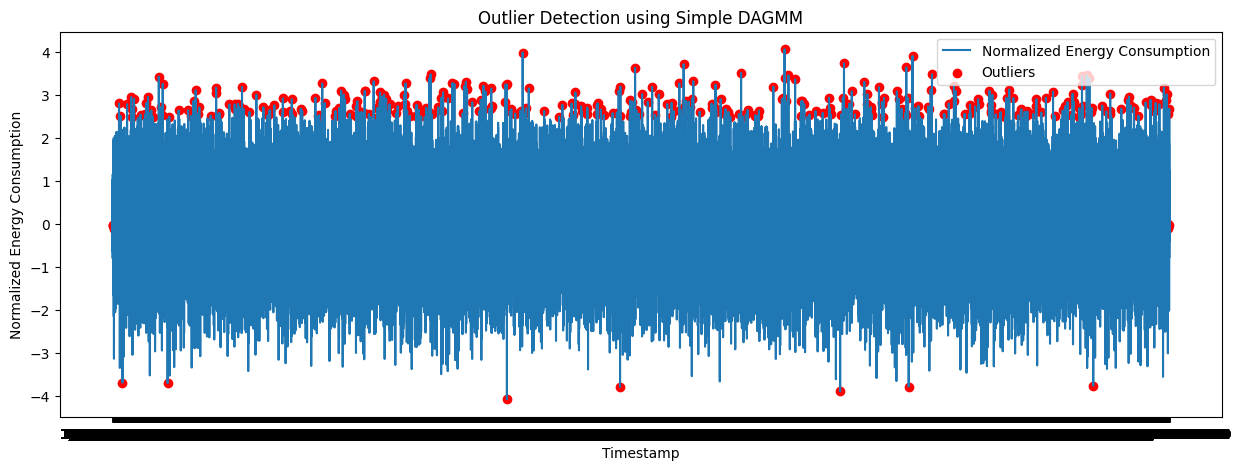

In [1]:
##########################Outlier Detection using Simple DAGMM #########Deep Autoencoding Gaussian Mixture Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# بارگذاری داده‌ها
df = pd.read_csv("D:/third semester/Casystudy2/2-Dataset/electricity_consumption-2.csv")
print(df.info())
print(df.head())
print(df.describe())

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# بارگذاری داده (فرضا df آماده است و ستون 'Energy Consumption (kWh)' داریم)
X = df[['Energy Consumption (kWh)']].values
X = (X - X.mean()) / X.std()  # نرمال سازی

# تعریف Autoencoder ساده
input_dim = X.shape[1]

input_layer = Input(shape=(input_dim,))
encoder = Dense(10, activation='relu')(input_layer)
encoder = Dense(5, activation='relu')(encoder)  # فضای latent
decoder = Dense(10, activation='relu')(encoder)
decoder = Dense(input_dim, activation=None)(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')

# آموزش Autoencoder
autoencoder.fit(X, X, epochs=50, batch_size=32, verbose=1)

# استخراج ویژگی‌های latent
encoder_model = Model(inputs=input_layer, outputs=encoder)
latent_feats = encoder_model.predict(X)

# برازش GMM روی فضای latent
gmm = GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(latent_feats)

# محاسبه احتمال نمونه‌ها
scores = gmm.score_samples(latent_feats)  # log-likelihood

# تعیین آستانه (مثلا در اینجا از کوانتیل استفاده می‌کنیم)
threshold = np.percentile(scores, 5)  # 5 درصد پایین‌ترین احتمال به عنوان پرت

outliers = scores < threshold

print(f"Number of outliers detected: {np.sum(outliers)}")

# رسم نتایج
plt.figure(figsize=(15,5))
plt.plot(df['Timestamp'], X, label='Normalized Energy Consumption')
plt.scatter(df['Timestamp'][outliers], X[outliers], color='red', label='Outliers')
plt.title('Outlier Detection using Simple DAGMM')
plt.xlabel('Timestamp')
plt.ylabel('Normalized Energy Consumption')
plt.legend()
plt.show()


# outliers یک آرایه بولی است که نقاط پرت را مشخص می‌کند
df_clean = df[~outliers]  # Drop the Outliers

print(f"Shape before removing outliers: {df.shape}")
print(f"Shape after removing outliers: {df_clean.shape}")



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52585 entries, 0 to 52584
Data columns (total 40 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Timestamp                            52585 non-null  object 
 1   Building Type                        52585 non-null  object 
 2   Energy Consumption (kWh)             52585 non-null  float64
 3   Temperature (C)                      52585 non-null  float64
 4   Humidity (per)                       52585 non-null  float64
 5   Occupancy Rate (per)                 52585 non-null  float64
 6   Lighting Consumption (kWh)           52585 non-null  float64
 7   HVAC Consumption (kWh)               52585 non-null  float64
 8   Energy Price (kWh)                   52585 non-null  float64
 9   Carbon Emission Rate (CO2/kWh)       52585 non-null  float64
 10  Power Factor                         52585 non-null  float64
 11  Voltage Levels (V)          

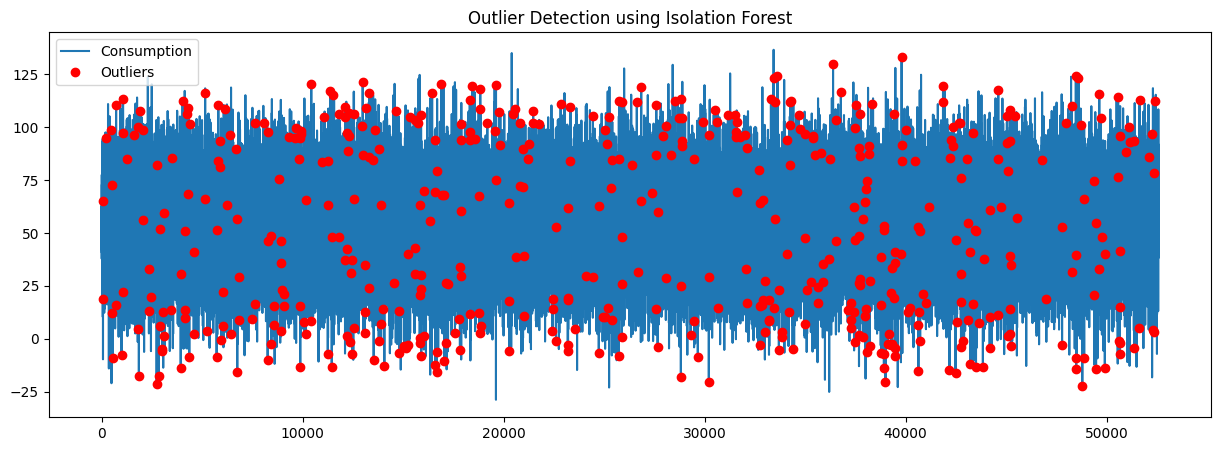

In [ ]:
####################### finding outler by Isolation Forest method ################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# بارگذاری داده‌ها
df = pd.read_csv("D:/third semester/Casystudy2/2-Dataset/electricity_consumption-2.csv")
print(df.info())
print(df.head())
print(df.describe())

# Isolation Forest for time series anomaly detection
from sklearn.ensemble import IsolationForest

# Create lag features for context
df_iforest = df[['Energy Consumption (kWh)']].copy()
df_iforest['lag1'] = df_iforest['Energy Consumption (kWh)'].shift(1)
df_iforest['lag2'] = df_iforest['Energy Consumption (kWh)'].shift(2)
df_iforest = df_iforest.dropna()

X_iforest = df_iforest.values
model_iforest = IsolationForest(contamination=0.01, random_state=42)
df_iforest['anomaly'] = model_iforest.fit_predict(X_iforest)

# Anomaly = -1 means outlier
outliers_iforest = df_iforest['anomaly'] == -1
print(f"[Isolation Forest] Number of outliers: {outliers_iforest.sum()}")

# Plot
plt.figure(figsize=(15,5))
plt.plot(df_iforest.index, df_iforest['Energy Consumption (kWh)'], label='Consumption')
plt.plot(df_iforest.index[outliers_iforest], df_iforest['Energy Consumption (kWh)'][outliers_iforest], 'ro', label='Outliers')
plt.title('Outlier Detection using Isolation Forest')
plt.legend()
plt.show()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52585 entries, 0 to 52584
Data columns (total 40 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Timestamp                            52585 non-null  object 
 1   Building Type                        52585 non-null  object 
 2   Energy Consumption (kWh)             52585 non-null  float64
 3   Temperature (C)                      52585 non-null  float64
 4   Humidity (per)                       52585 non-null  float64
 5   Occupancy Rate (per)                 52585 non-null  float64
 6   Lighting Consumption (kWh)           52585 non-null  float64
 7   HVAC Consumption (kWh)               52585 non-null  float64
 8   Energy Price (kWh)                   52585 non-null  float64
 9   Carbon Emission Rate (CO2/kWh)       52585 non-null  float64
 10  Power Factor                         52585 non-null  float64
 11  Voltage Levels (V)          

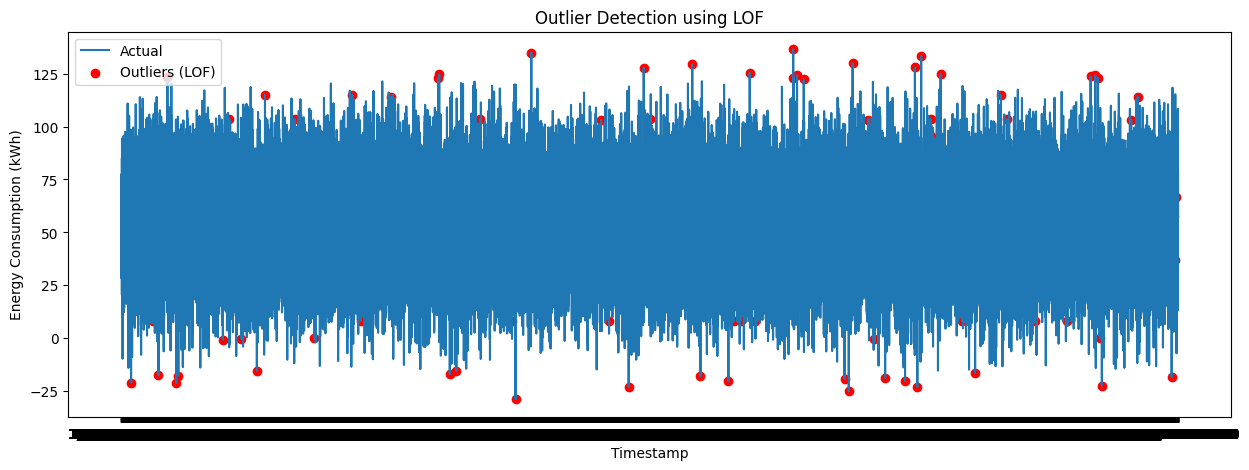

[LOF] Number of outliers: 526


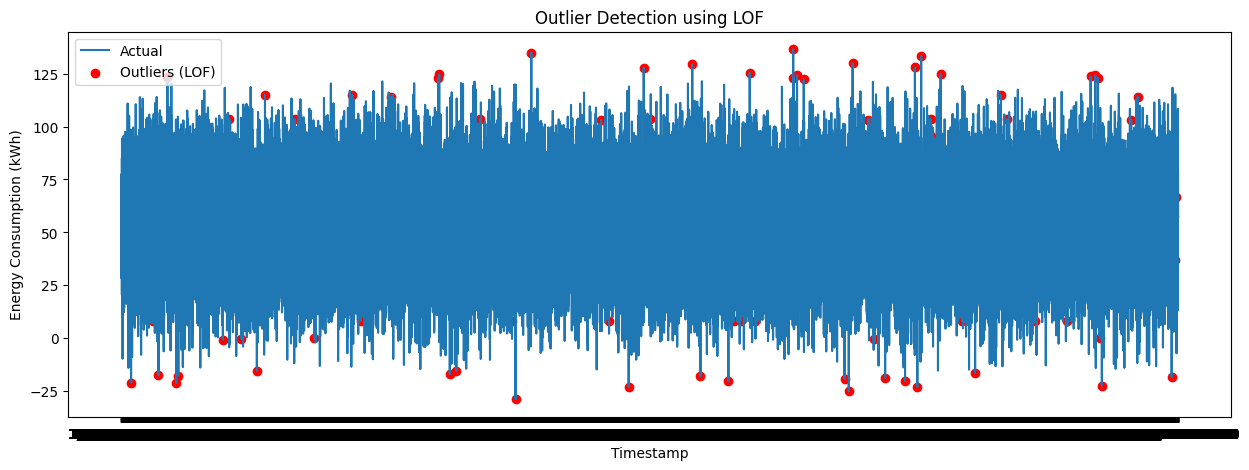

In [3]:
###############################3 finding outlier by LOF #################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# بارگذاری داده‌ها
df = pd.read_csv("D:/third semester/Casystudy2/2-Dataset/electricity_consumption-2.csv")
print(df.info())
print(df.head())
print(df.describe())

from sklearn.neighbors import LocalOutlierFactor
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Get the feature
X = df[['Energy Consumption (kWh)']].values  # must be 2D

# Step 2: Fit LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)  # contamination = expected outlier fraction
y_pred = lof.fit_predict(X)

# Step 3: Mark outliers (-1 = outlier)
outliers_lof = y_pred == -1
print(f"[LOF] Number of outliers: {np.sum(outliers_lof)}")

# Step 4: Plot
plt.figure(figsize=(15,5))
plt.plot(df['Timestamp'], X, label='Actual')
plt.scatter(df['Timestamp'][outliers_lof], X[outliers_lof], color='red', label='Outliers (LOF)', marker='o')
plt.title('Outlier Detection using LOF')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.show()
from sklearn.neighbors import LocalOutlierFactor
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Get the feature
X = df[['Energy Consumption (kWh)']].values  # must be 2D

# Step 2: Fit LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)  # contamination = expected outlier fraction
y_pred = lof.fit_predict(X)

# Step 3: Mark outliers (-1 = outlier)
outliers_lof = y_pred == -1
print(f"[LOF] Number of outliers: {np.sum(outliers_lof)}")

# Step 4: Plot
plt.figure(figsize=(15,5))
plt.plot(df['Timestamp'], X, label='Actual')
plt.scatter(df['Timestamp'][outliers_lof], X[outliers_lof], color='red', label='Outliers (LOF)', marker='o')
plt.title('Outlier Detection using LOF')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.show()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52585 entries, 0 to 52584
Data columns (total 40 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Timestamp                            52585 non-null  object 
 1   Building Type                        52585 non-null  object 
 2   Energy Consumption (kWh)             52585 non-null  float64
 3   Temperature (C)                      52585 non-null  float64
 4   Humidity (per)                       52585 non-null  float64
 5   Occupancy Rate (per)                 52585 non-null  float64
 6   Lighting Consumption (kWh)           52585 non-null  float64
 7   HVAC Consumption (kWh)               52585 non-null  float64
 8   Energy Price (kWh)                   52585 non-null  float64
 9   Carbon Emission Rate (CO2/kWh)       52585 non-null  float64
 10  Power Factor                         52585 non-null  float64
 11  Voltage Levels (V)          

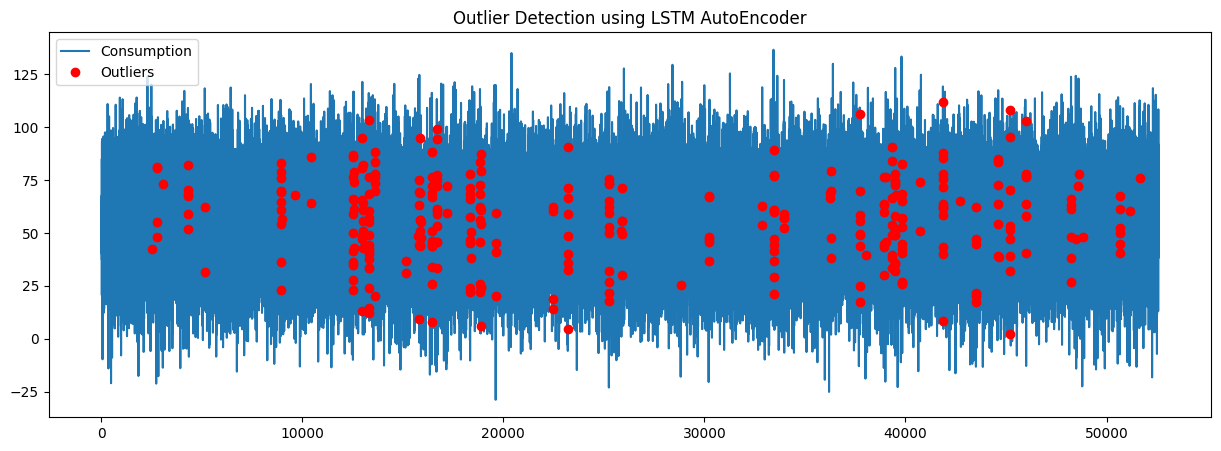

In [4]:
#################### finding outlier by LSTM AutoEncoder method ###########
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# بارگذاری داده‌ها
df = pd.read_csv("D:/third semester/Casystudy2/2-Dataset/electricity_consumption-2.csv")
print(df.info())
print(df.head())
print(df.describe())

# =========================================
# LSTM AutoEncoder method for outlier detection
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from sklearn.preprocessing import MinMaxScaler

# Prepare data for LSTM (reshape to 3D)
series_lstm = df['Energy Consumption (kWh)'].values.reshape(-1, 1)
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series_lstm)

# Windowing
def create_sequences(data, seq_length):
    X = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
    return np.array(X)

seq_length = 24
X_lstm = create_sequences(series_scaled, seq_length)

# Autoencoder Model
input_dim = X_lstm.shape[1:]
inputs = Input(shape=input_dim)
encoded = LSTM(64, activation='relu')(inputs)
decoded = RepeatVector(seq_length)(encoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
outputs = decoded

autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_lstm, X_lstm, epochs=10, batch_size=64, shuffle=False, verbose=0)

# Compute reconstruction error
X_pred = autoencoder.predict(X_lstm)
mse = np.mean(np.power(X_lstm - X_pred, 2), axis=(1, 2))
thresh = np.mean(mse) + 3 * np.std(mse)
outliers_lstm = mse > thresh

print(f"[LSTM] Number of outliers: {np.sum(outliers_lstm)}")

# Plot
plt.figure(figsize=(15,5))
plt.plot(df.index[seq_length:], series_lstm[seq_length:], label='Consumption')
plt.plot(df.index[seq_length:][outliers_lstm], series_lstm[seq_length:][outliers_lstm], 'ro', label='Outliers')
plt.title('Outlier Detection using LSTM AutoEncoder')
plt.legend()
plt.show()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52585 entries, 0 to 52584
Data columns (total 40 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Timestamp                            52585 non-null  object 
 1   Building Type                        52585 non-null  object 
 2   Energy Consumption (kWh)             52585 non-null  float64
 3   Temperature (C)                      52585 non-null  float64
 4   Humidity (per)                       52585 non-null  float64
 5   Occupancy Rate (per)                 52585 non-null  float64
 6   Lighting Consumption (kWh)           52585 non-null  float64
 7   HVAC Consumption (kWh)               52585 non-null  float64
 8   Energy Price (kWh)                   52585 non-null  float64
 9   Carbon Emission Rate (CO2/kWh)       52585 non-null  float64
 10  Power Factor                         52585 non-null  float64
 11  Voltage Levels (V)          

11:02:05 - cmdstanpy - INFO - Chain [1] start processing
11:02:13 - cmdstanpy - INFO - Chain [1] done processing


[Prophet] Number of outliers: 154


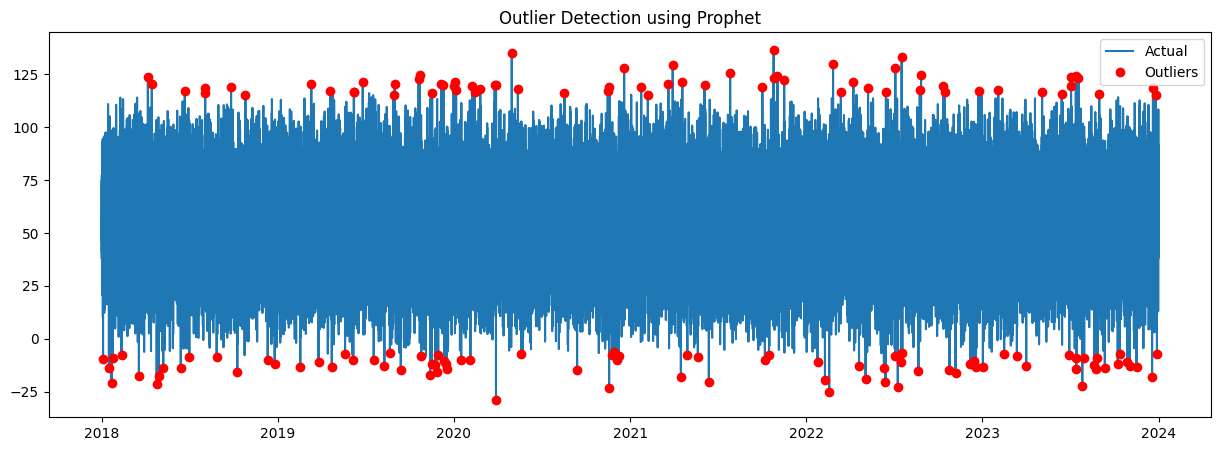

11:02:37 - cmdstanpy - INFO - Chain [1] start processing
11:02:45 - cmdstanpy - INFO - Chain [1] done processing


[Prophet] Number of outliers detected: 154


11:03:07 - cmdstanpy - INFO - Chain [1] start processing
11:03:17 - cmdstanpy - INFO - Chain [1] done processing



📈 ارزیابی مدل Prophet پس از حذف داده‌های پرت:
MAE: 15.9755
MSE: 398.1622
R²: 0.0006


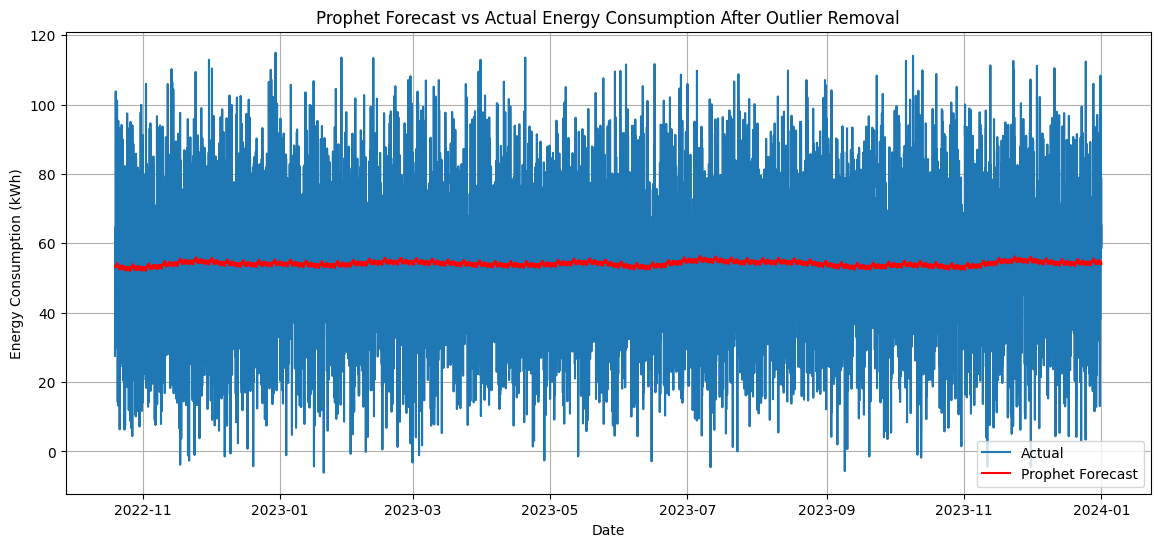

In [6]:
############################ finding outler by prorhet algorithim ###############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# بارگذاری داده‌ها
df = pd.read_csv("D:/third semester/Casystudy2/2-Dataset/electricity_consumption-2.csv")
print(df.info())
print(df.head())
print(df.describe())

from prophet import Prophet
import matplotlib.pyplot as plt

# حذف تاریخ‌های نادرست
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df = df.dropna(subset=['Timestamp'])

# آماده‌سازی برای Prophet
df_prophet = df[['Timestamp', 'Energy Consumption (kWh)']].rename(columns={
    'Timestamp': 'ds',
    'Energy Consumption (kWh)': 'y'
})

# آموزش مدل
model_prophet = Prophet()
model_prophet.fit(df_prophet)

# پیش‌بینی
future = model_prophet.make_future_dataframe(periods=0)
forecast = model_prophet.predict(future)

# تشخیص نقاط پرت
residuals = df_prophet['y'] - forecast['yhat']
z_prophet = (residuals - residuals.mean()) / residuals.std()
threshold = 3
outliers_prophet = abs(z_prophet) > threshold

print(f"[Prophet] Number of outliers: {outliers_prophet.sum()}")

# نمایش نمودار
plt.figure(figsize=(15,5))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual')
plt.plot(df_prophet['ds'][outliers_prophet], df_prophet['y'][outliers_prophet], 'ro', label='Outliers')
plt.title('Outlier Detection using Prophet')
plt.legend()
plt.show()

##########################3//////////////////////////
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# بارگذاری داده‌ها
df = pd.read_csv("D:/third semester/Casystudy2/2-Dataset/electricity_consumption-2.csv")

# تبدیل فرمت تاریخ و حذف تاریخ‌های نامعتبر
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df = df.dropna(subset=['Timestamp'])

# آماده‌سازی داده برای Prophet
df_prophet = df[['Timestamp', 'Energy Consumption (kWh)']].rename(columns={
    'Timestamp': 'ds',
    'Energy Consumption (kWh)': 'y'
})

# آموزش مدل Prophet روی کل داده‌ها برای تشخیص پرت
model_prophet = Prophet()
model_prophet.fit(df_prophet)

# پیش‌بینی روی همان داده‌ها (بدون آینده‌نگری)
future = model_prophet.make_future_dataframe(periods=0)
forecast = model_prophet.predict(future)

# محاسبه باقیمانده‌ها و z-score برای تشخیص پرت
residuals = df_prophet['y'] - forecast['yhat']
z_prophet = (residuals - residuals.mean()) / residuals.std()
threshold = 3
outliers_prophet = abs(z_prophet) > threshold

print(f"[Prophet] Number of outliers detected: {outliers_prophet.sum()}")

# حذف نقاط پرت از دیتافریم
df_clean = df_prophet.loc[~outliers_prophet].reset_index(drop=True)

# آموزش مجدد مدل Prophet روی داده‌های تمیز شده
model_clean = Prophet()
model_clean.fit(df_clean)

# تقسیم داده تمیز به train و test
train_size = int(len(df_clean) * 0.8)
train = df_clean.iloc[:train_size]
test = df_clean.iloc[train_size:]

# پیش‌بینی روی داده تست
future_clean = model_clean.make_future_dataframe(periods=len(test), freq='D')
future_clean = future_clean.iloc[:len(train) + len(test)]  # فقط تا آخر داده تست
forecast_clean = model_clean.predict(future_clean)

# آماده‌سازی داده برای ارزیابی
df_eval = forecast_clean[['ds', 'yhat']].merge(test[['ds', 'y']], on='ds', how='inner')

y_true = df_eval['y'].values
y_pred = df_eval['yhat'].values

# محاسبه معیارهای ارزیابی
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("\n📈 ارزیابی مدل Prophet پس از حذف داده‌های پرت:")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

# نمایش نمودار پیش‌بینی در برابر واقعی
plt.figure(figsize=(14, 6))
plt.plot(df_eval['ds'], y_true, label='Actual')
plt.plot(df_eval['ds'], y_pred, label='Prophet Forecast', color='red')
plt.legend()
plt.title("Prophet Forecast vs Actual Energy Consumption After Outlier Removal")
plt.xlabel("Date")
plt.ylabel("Energy Consumption (kWh)")
plt.grid()
plt.show()



In [ ]:
######################finding outler by REHWS method ##############
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# بارگذاری داده‌ها
df = pd.read_csv("D:/third semester/Casystudy2/2-Dataset/electricity_consumption-2.csv")
print(df.info())
print(df.head())
print(df.describe())

import numpy as np
import matplotlib.pyplot as plt

# Step 1: Series
series = df['Energy Consumption (kWh)'].copy()

# Step 2: EWM mean
ewm_mean = series.ewm(span=10, adjust=False).mean()

# Step 3: MAD
mad = np.median(np.abs(series - np.median(series)))

# Step 4: Robust Z-Score
z_rehws = (series - ewm_mean) / (1.4826 * mad)

# Step 5: Detect outliers
threshold = 3
outliers_rehws = abs(z_rehws) > threshold
print(f"[REHWS] Number of outliers: {outliers_rehws.sum()}")


# Step 6: Plot
plt.figure(figsize=(15,5))
plt.plot(df['Timestamp'], series, label='Actual')
plt.plot(df['Timestamp'][outliers_rehws], series[outliers_rehws], 'ro', label='Outliers')
plt.title('Outlier Detection using REHWS')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.show()  # ← this makes the plot appear




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52585 entries, 0 to 52584
Data columns (total 40 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Timestamp                            52585 non-null  object 
 1   Building Type                        52585 non-null  object 
 2   Energy Consumption (kWh)             52585 non-null  float64
 3   Temperature (C)                      52585 non-null  float64
 4   Humidity (per)                       52585 non-null  float64
 5   Occupancy Rate (per)                 52585 non-null  float64
 6   Lighting Consumption (kWh)           52585 non-null  float64
 7   HVAC Consumption (kWh)               52585 non-null  float64
 8   Energy Price (kWh)                   52585 non-null  float64
 9   Carbon Emission Rate (CO2/kWh)       52585 non-null  float64
 10  Power Factor                         52585 non-null  float64
 11  Voltage Levels (V)          